# Evaluate landfall decay rates for tropical cyclones in the Australian region

This notebook analyses the historical best track data from [IBTrACS](http://www.ncdc.noaa.gov/oa/ibtracs/) to evaluate the rate of decay of cyclones after landfall. 

In previous studies, the rate of change of central pressure deficit ($\Delta p_c$) is modelled as an exponential decay function:

$\Delta p_c(t) = \Delta p_0 e^{(-\alpha t)}$

where $\alpha = \alpha_0 + \alpha_1 \Delta p_0$ and $\Delta p_0$ is the central pressure deficit at landfall. Here, we are attempting to fit this model to TC occurrences in the Australian region. 


In [1]:
%matplotlib inline

from __future__ import print_function
import numpy as np
import pandas as pd

from scipy.optimize import leastsq
import io

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from Utilities.loadData import loadTrackFile
from Utilities.config import ConfigParser

from Utilities.track import Track

import seaborn
seaborn.set_context("poster")

Define the configuration settings for the analysis. You will need to have the latest version of the IBTrACS data and the daily long term mean sea level pressure data stored locally. Modify the path to those files as required.

To modify the region analysed, change the `gridLimit` option in the `Region` section. You can restrict the TC seasons used by modifying the `StartSeason` option in the `DataProcess` section. 

In [67]:
configstr = """
[DataProcess]
InputFile=C:/WorkSpace/data/TC/Allstorms.ibtracs_wmo.v03r06.csv
Source=IBTRACS
StartSeason=1901
FilterSeasons=True

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':143.40,'xMax':156,'yMin':-28.0,'yMax':-9.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[Input]
landmask = C:/WorkSpace/tcrm/input/landmask.nc
mslpfile = C:/WorkSpace/data/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r06.csv.gz
path = C:/WorkSpace/data/TC/
filename = Allstorms.ibtracs_wmo.v03r06.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = C:/WorkSpace/data/MSLP
filename = slp.day.ltm.nc
"""

Load the configuration settings from the string representation above. Normally, this would be stored in a file and read directly from there. 

In [68]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))

Load the track file. This reports the number of tracks loaded - this varies based on the `StartSeason` option in the `DataProcess` section above. Tracks for all basins are loaded by default, and then we filter spatially at a later step.

In [69]:
trackFile = config.get('DataProcess', 'InputFile')
source = config.get('DataProcess', 'Source')

print("Track file: {0}".format(trackFile))
print("Track format: {0}".format(source))
tracks = loadTrackFile(configstr, trackFile, source)
print("There are {0:d} tracks in the input dataset".format(len(tracks)))

Track file: C:/WorkSpace/data/TC/Allstorms.ibtracs_wmo.v03r06.csv
Track format: IBTRACS
There are 6479 tracks in the input dataset


Set up a map to define the study region. 

In [70]:
domain = config.geteval('Region', 'gridLimit')
mapkwargs = dict(llcrnrlon=domain['xMin'],
                 llcrnrlat=domain['yMin'],
                 urcrnrlon=domain['xMax'],
                 urcrnrlat=domain['yMax'],
                 resolution='h',
                 projection='cyl')
m = Basemap(**mapkwargs)



This function identifies the landfall pressure deficit and time, then extracts the pressure deficit at all times after landfall.

It returns the initial pressure deficit $\Delta p_{0}$, the pressure deficit $\Delta p_c (t)$ at each subsequent point in time, and the time after landfall $t$ (in hours). 

In [71]:
def processTrack(track, m):
    onland = np.zeros(len(track.Longitude))
    dp0 = 0
    for i, (lon, lat) in enumerate(zip(track.Longitude, 
                                      track.Latitude)):
        if m.is_land(lon, lat):
            onland[i] = 1

    dp = []
    dt = []
    flag = 0
    for i in range(1, len(onland)):
        if (onland[i]==1) & (onland[i-1]==0) & (track.CentralPressure[i-1] > 0.0):
            # New landfall (with central pressure prior to landfall):
            t0 = track.TimeElapsed[i-1]
            dp0 = track.EnvPressure[i-1] - track.CentralPressure[i-1]
            flag = 1
        
        if (flag==1) & (track.CentralPressure[i] > 0.0):
            # Storm is on land and has a valid central pressure record:
            dp.append(track.EnvPressure[i] - track.CentralPressure[i])
            dt.append(track.TimeElapsed[i] - t0)
            flag = onland[i]
            if flag == 0:
                return dp0, dp, dt
    if len(dp) > 0:
        dpdt = (dp0 - np.array(dp))/np.array(dt)

        return dp0, dp, dt
    else:
        return None, None, None
        

Define a group of functions to fit the pressure deficit (as a function of time after landfall) to an exponential decay model. We also create the same to fit the decay rate to a linear function of the landfall pressure deficit $\Delta p_0$. 

In [72]:
def decayresiduals(params, dp, dt, dp0):
    yfit = dp0 * np.exp(-(np.array(params) * dt))
    return dp - yfit

def minimise_decay(dp, dt, dp0, alpha=0., beta=1.):
    plsq = leastsq(decayresiduals, [alpha], args=(dp, dt, dp0))
    return plsq[0]

def paramresiduals(params, alpha, dp0):
    yfit = np.array(params[0]) + np.array(params[1]) * dp0
    return alpha - yfit

def minimise_alpha(alpha, dp0, a0, a1):
    plsq = leastsq(paramresiduals, [a0, a1], args=(alpha, dp0))
    return plsq[0]

Cycle through all the tracks in the input dataset. If the track passes through the study region, then we will process it to obtain the decay rate as a function of $\Delta p_0$ and $t$. The fitted decay rate is added to a list of values, as is the landfall pressure value.

The time history of each event is then plotted -- both the central pressure deficit ($\Delta p_c(t)$) and the central pressure deficit normalised by the landfall pressure deficit ($\Delta p_0$).

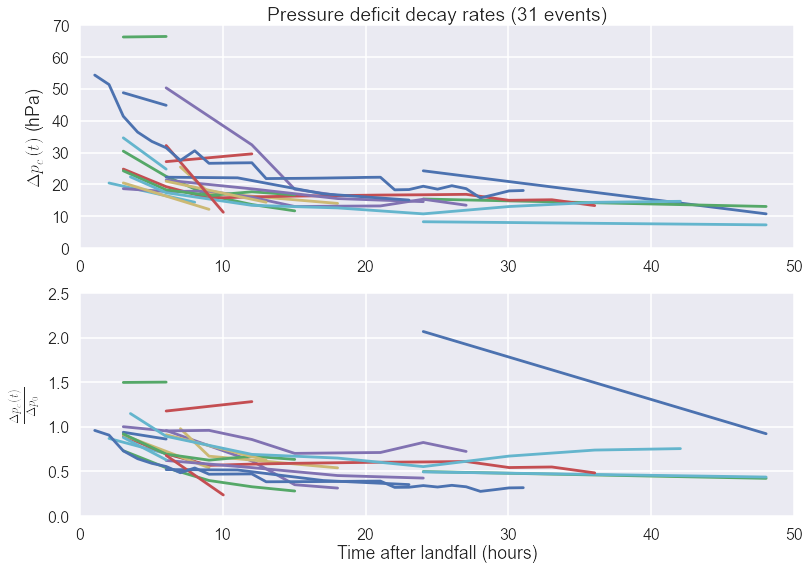

In [73]:
landfall_pressure = []
decayrate = []
nevents=0
fig1, (ax1, ax2) = plt.subplots(2,1)

for n, track in enumerate(tracks):
    if track.inRegion(domain):
        # Process the track to get the pressure at landfall and the decay rate thereafter:
        dp0, dp, dt = processTrack(track, m)
        if dp0 is not None:
            nevents += 1
            ax1.plot(dt, dp)
            ax2.plot(dt, (dp/dp0))
            p = minimise_decay(dp, dt, dp0, 0., 1.)
            decayrate.append(p[0])
            landfall_pressure.append(dp0)
    
ax2.set_xlabel("Time after landfall (hours)")
ax1.set_ylabel("$\Delta p_c(t) $ (hPa)")
ax1.set_title("Pressure deficit decay rates ({0} events)".format(nevents))
ax2.set_ylabel(r"$\frac{\Delta p_c(t)}{\Delta p_0}$")


Now fit the decay rate $\alpha$ as a linear model of landfall pressure deficit $\Delta p_0$. The plot shows the 95% approximate confidence interval (shaded), based on a bootstrap resampling of the data. 

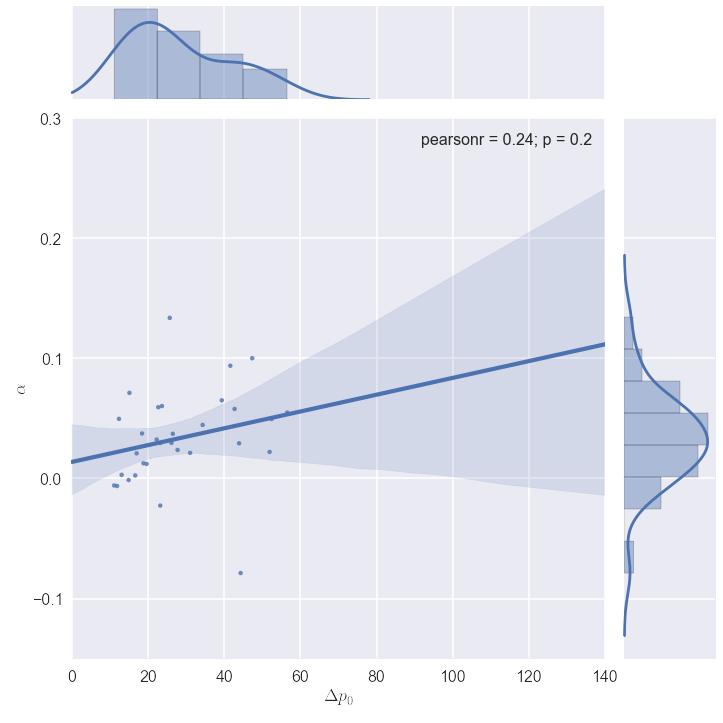

In [78]:
df = pd.DataFrame({'alpha':decayrate,
                   'dp0':landfall_pressure})
jp = seaborn.jointplot('dp0','alpha',df, kind='reg', size=10,xlim=(0,140))
jp.set_axis_labels(r"${\Delta p_0}$", r"$\alpha$")

In [79]:
ap = minimise_alpha(decayrate, landfall_pressure, 0, 0)
print(ap)

[ 0.01415941  0.00070029]


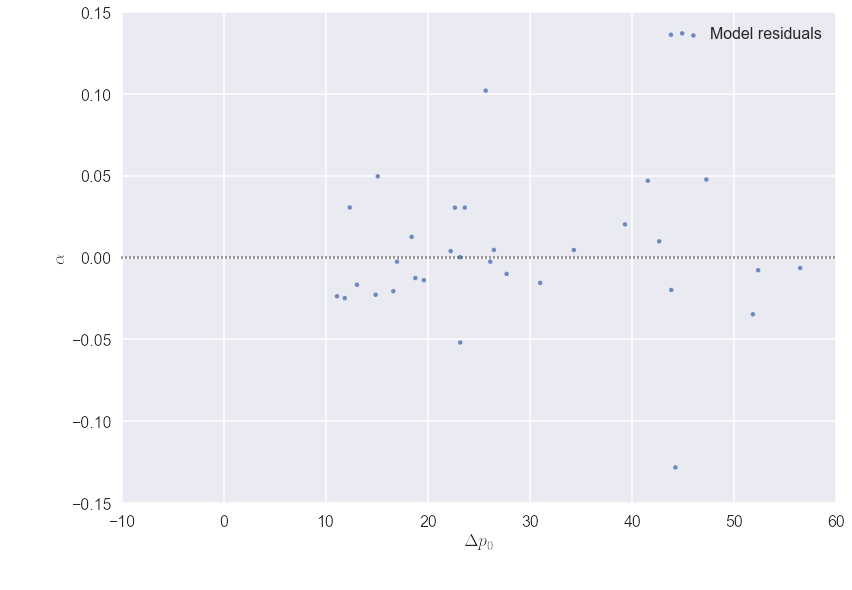

In [80]:
ax4 = seaborn.residplot('dp0','alpha',df,robust=True,label="Model residuals")
ax4.set_xlabel(r"${\Delta p_0}$")
ax4.set_ylabel(r"$\alpha$")
ax4.legend(loc=0)

This document was written in an IPython notebook. The raw notebook can be downloaded [here](https://github.com/wcarthur/notebooks/blob/master/TC%20landfall%20decay.ipynb). See also [nbviewer](http://nbviewer.ipython.org/github/wcarthur/notebooks/blob/master/TC%20landfall%20decay.ipynb) for an online static view.